In [1]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from sine_data import train_dataset, valid_dataset

In [4]:
NUM_POINTS = 200

X_train, y_train = train_dataset(points=NUM_POINTS)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=NUM_POINTS)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [5]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, timestep_divisor):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.timestep_divisor = timestep_divisor
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.timestep_divisor)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y[:,-1])
        return torch.stack(ys, dim=1), h

In [6]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [7]:
class RepeatingRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        repeats = ceil(target_length / x.size(1))
                
        parts = []
        for ti in range(x.size(1)):
            xr = x[:, ti:(ti+1)].repeat(1, repeats, 1)
            parts.append(xr)
        
        x_rep = torch.cat(parts, dim=1)
        y, h = self.rnn_layer(x_rep)
        return y[:, :target_length], h

In [8]:
class ContextDecoderRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        # at time-step (target_length % x.size(1)) switch context to next value from x
        cidx = 0
        h = x[:, cidx:(cidx+1)].transpose(0, 1) # make context (t, b, u)
        y_tm1 = Variable(torch.zeros(x.size(0), 1, x.size(-1)))
        y_tm1 = y_tm1.cuda() if x.is_cuda else y_tm1
        ys = []
        # every nth step an update happens
        update_step = ceil(target_length / x.size(1))
        for ti in range(target_length):
            y, h_new = self.rnn_layer(y_tm1, h)
            ys.append(y)
            y_tm1 = y
            if ti > 0 and ti % update_step == 0:
                h = x[:, cidx:(cidx+1)].transpose(0, 1)
                cidx += 1
        return torch.stack(ys, dim=1), h

In [ ]:
class OutputtingContextDecoderRNN(nn.Module):
    produces_output = True
    
    def __init__(self, rnn_layer, out_dim):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.out_dim = out_dim
        
        self.hid2clf = nn.Linear(rnn_layer.hidden_size, out_dim)
        self.clf2hid = nn.Linear(out_dim, rnn_layer.hidden_size)
        
    def forward(self, x, target_length):
        # at time-step (target_length % x.size(1)) switch context to next value from x
        cidx = 0
        h = x[:, cidx:(cidx+1)].transpose(0, 1) # make context (t, b, u)
        y_tm1 = Variable(torch.zeros(x.size(0), 1, x.size(-1)))
        y_tm1 = y_tm1.cuda() if x.is_cuda else y_tm1
        ys = []
        # every nth step an update happens
        update_step = ceil(target_length / x.size(1))
        for ti in range(target_length):
            y, h_new = self.rnn_layer(y_tm1, h)
            y = time_unflatten(self.hid2clf(time_flatten(y)), y.size())
            y_tm1 = time_unflatten(self.clf2hid(time_flatten(y)), y.size())
            ys.append(y)
            if ti > 0 and ti % update_step == 0:
                h = x[:, cidx:(cidx+1)].transpose(0, 1)
                cidx += 1
        return torch.stack(ys, dim=1), h

In [ ]:
class MLPDecoder(nn.Module):
    def __init__(self, input_dim, input_length, output_dim, target_length):
        super().__init__()
        self.output_dim = output_dim
        self.target_length = target_length
        self.m = nn.Linear(input_dim * input_length, output_dim * target_length)
        
    def forward(self, x, _):
        # from N sized chunk predict M length with size U
        # so: N -> (M * U) which can then be transformed to (M, U)
        y = self.m(x.view(-1, x.size(1) * x.size(2)))
        return y.view(-1, self.target_length, self.output_dim), None

In [ ]:
class ConcatS2SDecoder(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        # at time-step target_length % x.size(1) switch context to next value from x
        h = torch.cat(x, dim=1).transpose(0, 1) # make context (t, b, u)
        y_tm1 = Variable(torch.zeros(x.size(0), 1, x.size(-1)))
        y_tm1 = y_tm1.cuda() if x.is_cuda else y_tm1
        ys = []
        # every nth step an update happens
        for ti in range(target_length):
            y, h_new = self.rnn_layer(y_tm1, h)
            ys.append(y)
            y_tm1 = y
            h = y_tm1.transpose(0, 1)
        return torch.stack(ys, dim=1), h

In [ ]:
class ReconModel(nn.Module):
    def __init__(
        self, 
        num_hidden=16, 
        timestep_divisor_0=20, 
        timestep_divisor_1=2, 
        baseline=False,
    ):
        super().__init__()
        
        # t -> ceil(t/20) timesteps
        layer_0 = nn.GRU(1, num_hidden, batch_first=True)
        self.rnn_enc_0 = ClipBPTTWrapper(layer_0, num_hidden, timestep_divisor_0)

        # ceil(t/20) -> ceil(ceil(t/20)/2) timesteps
        layer_1 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_enc_1 = ClipBPTTWrapper(layer_1, num_hidden, timestep_divisor_1)
                
        # ceil(ceil(t/20)/2) chunks total as hidden repr. (3 for t=100)
        # so we now want 3 -> 100 again (recon task)
        # we do this by generating 100//3 for each chunk
        layer_2 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        #self.rnn_dec_1 = RepeatingRNN(layer_2)
        #self.rnn_dec_1 = ContextDecoderRNN(layer_2, clf)
        self.rnn_dec_1 = OutputtingContextDecoderRNN(layer_2, out_dim)
#         self.rnn_dec_1 = MLPDecoder(
#             num_hidden, 
#             ceil(ceil((NUM_POINTS-1)/timestep_divisor_0)/timestep_divisor_1),
#             num_hidden,
#             NUM_POINTS - 1)
        #self.rnn_dec_1 = ConcatS2SDecoder(layer_2)
        #self.rnn_dec_1 = MergingContextDecoderRNN(layer_2)

        if not hasattr(self.rnn_dec_1, 'produces_output'):
            self.clf = clf

    def forward(self, x):
        l0, h0 = self.rnn_enc_0(x)
        l1, h1 = self.rnn_enc_1(l0)
        l2, h2 = self.rnn_dec_1(l1, x.size(1))
        #print('l0', l0.size(), 'l1', l1.size(), 'l2', l2.size())
        if hasattr(self.rnn_dec_1, 'produces_output'):
            return l2
        else:
            clf = self.clf(l2)
            return time_unflatten(clf, x.size())

In [ ]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [ ]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.008,
             max_epochs=120,
             train_split=my_train_split,
             
             module__num_hidden=8,
             module__timestep_divisor_0=4,
             module__timestep_divisor_1=4,
            )

In [ ]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

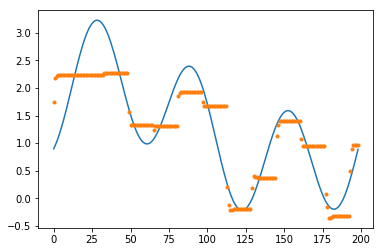

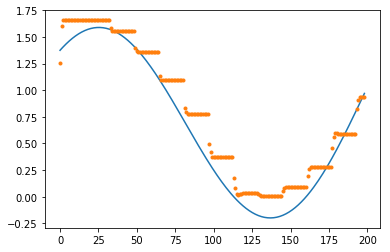

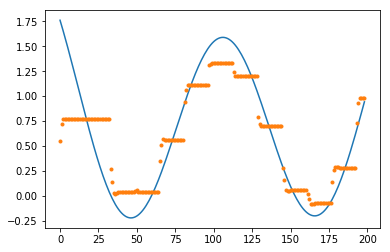

In [45]:
data = X_valid[:, :-1]
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i], '.')